In [1]:
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from scipy.stats import binom
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE


In [2]:
cycle_data = pd.read_csv("FedCycleData071012.csv")

# Data Cleaning

In [22]:
## fill empty `EstimatedDayOfOvulation` with mean for that individual
replace_str = cycle_data.at[1639,'EstimatedDayofOvulation']
cycle_data['EstimatedDayofOvulation'].replace(replace_str,np.nan,inplace=True)
cycle_data['EstimatedDayofOvulation'].replace([np.inf, -np.inf], np.nan, inplace=True)
cycle_data['EstimatedDayofOvulation'] = cycle_data['EstimatedDayofOvulation'].astype(float)
cycle_data['EstimatedDayofOvulation'] = cycle_data['EstimatedDayofOvulation'].fillna(cycle_data.groupby('ClientID')['EstimatedDayofOvulation'].transform('mean'))

# if there are extra NaNs, replace those with the mean for the dataset
cycle_data['EstimatedDayofOvulation'].fillna(cycle_data['EstimatedDayofOvulation'].mean(),inplace=True)
cycle_data['EstimatedDayofOvulation'] = cycle_data['EstimatedDayofOvulation'].round(0).astype(int)

In [181]:
data = cycle_data.loc[cycle_data["ClientID"] == 'nfp8122']

In [182]:
y = data["LengthofCycle"]

In [183]:
#train test split
y_train, y_test = np.array(y[:37]), np.array(y[37:])

In [497]:
def Predict(predict,n,alpha,mu):
    '''
    Parameters:
    pred: array (2,) - for IMAR(2), the first 2 observations
    n: Desired number of predictions
    alpha: values of alpha
    ps: values of p -- bernoulli perameter
    mu: mean of poission rv -- the epsilon
    Returns:
    y_predict array (n+2,)- predictions for next n observatiosns, with pred at the beginning
    '''
    y_predict = predict.copy()
    for i in range(n):
        new = np.sum([np.random.binomial(1, alpha[0])  for i in range(y_predict[-1])]) +np.sum([np.random.binomial(1,alpha[1]) for i in range(y_predict[-2])])
        new += np.sum([np.random.binomial(1, alpha[2])  for i in range(y_predict[-3])]) + np.random.poisson(mu)
        y_predict.append(int(new))
        
    return y_predict
        
    

In [678]:
### grid search for parameters


alphas  = [(.35,.25,.25),(.35,.25,.12),(.25,.25,.25),(.5,.25,.25),(.8,.1,.1)]


means = [1,2,3,4,5]
pred = [y_train[0],y_train[1], y_train[2]]

min_score = np.inf

for alpha in alphas:
    
    for mu in means:

        prediction = Predict(pred,34,alpha,mu) #try to match training set
        score = MSE(y_train,prediction) #use MSE to see how far from actual training set
        if score < min_score:
            best_params = (alpha, mu)
            min_score = score

            
            
            
        

In [679]:
#print(best_params)
alpha, mu = best_params

In [680]:
alpha,mu, min_score

((0.35, 0.25, 0.25), 5, 38.486486486486484)

In [697]:
pred = [y_train[-3], y_train[-2], y_train[-1]]
total1 = np.array(Predict(pred,8,alpha,mu))[3:]
total2 = np.array(Predict(pred,8,alpha,mu))[3:]

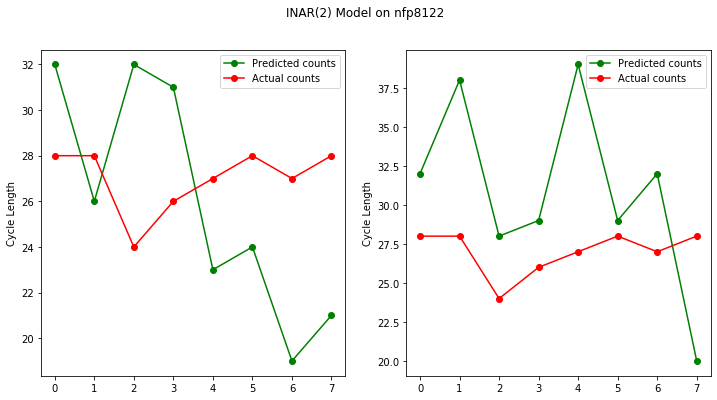

In [698]:
#predicted_counts=inar_predictions
actual_counts = y_test.reshape(1,-1)[0]
fig = plt.figure(figsize = (12,6))
fig.suptitle("INAR(2) Model on nfp8122")
plt.subplot(121)
predicted, = plt.plot( total1, 'go-', label='Predicted counts')
actual, = plt.plot( actual_counts, 'ro-', label='Actual counts')
plt.ylabel("Cycle Length")
plt.legend(handles=[predicted, actual])
plt.subplot(122)
predicted, = plt.plot( total2, 'go-', label='Predicted counts')
actual, = plt.plot( actual_counts, 'ro-', label='Actual counts')
plt.ylabel("Cycle Length")
plt.legend(handles=[predicted, actual])
plt.savefig("INAR_nfp8122_model_1")
plt.show()

In [654]:
#This is to average over many trials

total1 = np.zeros(8)

for i in range(10):
    prediction = np.array(Predict(pred,8,alpha,mu))[3:]
    total1 += prediction
    
total1/= 10


total2 = np.zeros(8)

for i in range(100):
    prediction = np.array(Predict(pred,8,alpha,mu))[3:]
    total2 += prediction
    
total2/= 100

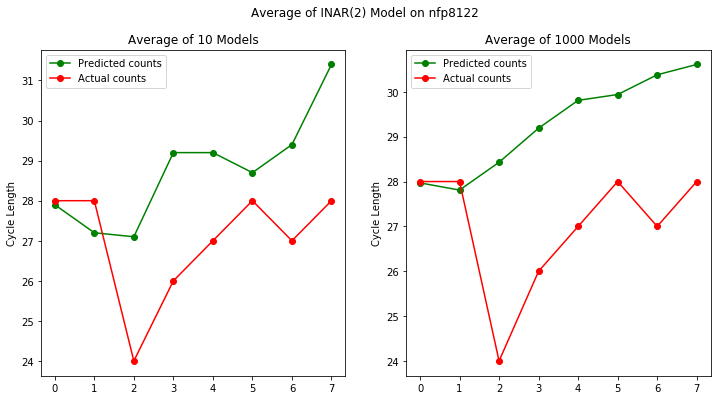

In [655]:
#predicted_counts=inar_predictions
actual_counts = y_test.reshape(1,-1)[0]
fig = plt.figure(figsize = (12,6))
fig.suptitle("Average of INAR(2) Model on nfp8122")
plt.subplot(121)
predicted, = plt.plot( total1, 'go-', label='Predicted counts')
actual, = plt.plot( actual_counts, 'ro-', label='Actual counts')
plt.ylabel("Cycle Length")
plt.legend(handles=[predicted, actual])
plt.title("Average of 10 Models")
plt.subplot(122)
predicted, = plt.plot( total2, 'go-', label='Predicted counts')
actual, = plt.plot( actual_counts, 'ro-', label='Actual counts')
plt.ylabel("Cycle Length")
plt.legend(handles=[predicted, actual])
plt.title("Average of 1000 Models")
plt.savefig("INAR_nfp8122_model_avg_")
plt.show()